# TP 01 - Optimization for Machine Learning

### Gustavo Duarte Tomaz de Sá
### Leonardo Hannas de Carvalho Santos

**The report is presented in the python notebook itself. All the mathematical developments are presented in the report. The code is also commented when needed in order to explain the different steps of the algorithm.**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [5]:
# Loading data
data_matrix_train, COP_train, data_matrix_test, COP_test, names = np.load('data_center_data_matrix.npy', allow_pickle=True)

In [6]:
# Constructing matrices for min_w ||A w - b||_2**2

matrix_mean = np.mean(data_matrix_train, axis=0)
M = data_matrix_train - matrix_mean
matrix_std = np.std(M, axis=0)
M = M / matrix_std

A = np.hstack([M, np.ones((M.shape[0],1)), -(M.T * COP_train[:,3]).T])
b = COP_train[:,3]

In [7]:
# Constructing matrices for the test set

M_test = (data_matrix_test - matrix_mean) / matrix_std
A_test = np.hstack([M_test, np.ones((M_test.shape[0],1)), -(M_test.T * COP_test[:,3]).T])
b_test = COP_test[:,3]

In [8]:
# Loading raw data

data = pd.read_csv('Raw_Dataset_May.csv')

def name_to_subcategory_and_details(col_name):
    if np.isreal(col_name):
        col_name = names[col_name]
    indices = np.nonzero((data['NAME'] == col_name).values)[0]
    if len(indices) > 0:
        subcategory = data['SUBCATEGORY'].iloc[[indices[0]]].values[0]
        details = data['DETAILS'].iloc[[indices[0]]].values[0]
        return subcategory, details
    else:
        print('unknown name')


# 3. Least Squares 

**In order to fit this model to the data, we first standardize the data. Indeed, the measurements may have various units (like $\mathrm{kWh}$, degree Celsius, $\mathrm{V}$, etc) and it makes more sense to separate the statistical aspects from these dimensionality considerations. Hence, we consider the matrix $\tilde{x}$, which is such that each of its columns has mean and standard deviation respectively 0 and 1 over the training set. (Note that we do not use the test set to do this standardization.)**

**We then solve the following least squares problem**

$$
\min _{w} \frac{1}{2}\|A w-b\|^{2}
$$

**where $(A w)_{t}=\tilde{x}(t)^{\top} w_{1}+w_{0}-y(t) \times \tilde{x}(t)^{\top} w_{2}$ for all $t$ and $b_{t}=y(t)$.**

## Question 3.1

**Show that if $A\omega = b$, then $y(t) = \frac{\omega_{1}^{T}\widetilde{x}(t) + \omega_{0}}{\omega_{2}^{T}\widetilde{x}(t) + 1}$.**

We know that the $t^{th}$ element of $A\omega$, as well as the $t^{th}$ element of $b$ are given by:

$$
\left\{\begin{matrix}
(A\omega)_{t} = \widetilde{x}(t)^{T} \omega_{1} + \omega_{0} - y(t) \times \widetilde{x}(t)^{T} \omega_{2}
\\ 
b_{t} = y(t)
\end{matrix}\right.
$$

Then, it follows that, for every $t$, 

$$
(A\omega)_{t} = b_{t} \iff
\widetilde{x}(t)^{T} \omega_{1} + \omega_{0} - y(t) \times \widetilde{x}(t)^{T} \omega_{2} = y(t) \iff
\widetilde{x}(t)^{T} \omega_{1} + \omega_{0} = y(t) \times \widetilde{x}(t)^{T} \omega_{2} + y(t) \iff
$$

$$
y(t) = \frac{\widetilde{x}(t)^{T} \omega_{1} + \omega_{0}}{\widetilde{x}(t)^{T} \omega_{2} + 1} \iff
y(t) = \frac{\omega_{1}^{T} \widetilde{x}(t) + \omega_{0}}{\omega_{2}^{T} \widetilde{x}(t) + 1}
$$








## Question 3.2

**Solve this least squares problem using the function `numpy.linalg.lstsq`**

In [9]:
A_train = A
A_train.shape

(722, 1785)

In [10]:
A_test.shape

(361, 1785)

In [11]:
b_train = b
b_train.shape

(722,)

In [12]:
b_test.shape

(361,)

In [13]:
# Train the model Aw = b
w_train = np.linalg.lstsq(A, b, rcond=None)[0]
w_train
len(w_train)

1785

## Question 3.3
**Evaluate the quality of the solution found on the test set**

In [14]:
new_b = A_test @ w_train
new_b.shape

(361,)

In [15]:
# Calculate the Root Mean Squared Error
mse = mean_squared_error(new_b, b_test)
print(f"Root Mean Squared Error: {mse}")

Root Mean Squared Error: 780.8984793523309


## Question 3.4

**In order to improve the generalization power of the model, we consider a $\ell_{2}$ regularization :**


$$
\min _{w} \frac{1}{2}\|A w-b\|^{2}+\frac{\lambda}{2}\|w\|^{2}
$$

**where $\lambda=100$. Solve this problem and compare the test mean square error with the unregularized one.**

First, we calculate the gradient of the function. By definition:

$$
f(w+h) = \frac{1}{2}\|A(\omega + h) -b\|^{2} + \frac{\lambda}{2}\|\omega+h\|^{2}
$$

$$
= \frac{1}{2}\|A \omega -b + A h\|^{2} + \frac{\lambda}{2}\|\omega+h\|^{2}
$$

$$
= \frac{1}{2}\left\|A \omega-b\right\|^{2}+\left\langle A \omega-b, A h\right\rangle+\frac{1}{2}\left\|A h\right\|^{2}+\frac{\lambda}{2}\left\|\omega\right\|^{2}+\lambda\left\langle \omega, h\right\rangle+\frac{\lambda}{2}\left\|h\right\|^{2}
$$

$$
= f_1(\omega) + \left\langle A \omega-b, A h\right\rangle + \lambda\left\langle \omega, h\right\rangle + o_1(h)
$$

$$
= f_1(\omega) + \left\langle A^{T}(A \omega-b) + \lambda \omega, h\right\rangle + o_1(h)
$$

Since, the first element of the product is the gradient of $f_1(\omega)$, we have:

$$
\nabla f(\omega) = A^{T}(A \omega-b) + \lambda \omega
$$

After obtaining the gradient, taking it equal to 0 (and assuming the function to be convex) we will find the minimization solution vector w:

$$
\nabla f(\omega) = 0 \Rightarrow A^{T}(A \omega-b) + \lambda \omega = 0
$$

$$
A^{T}A \omega + \lambda \omega = A^{T}b	
$$

$$
(A^{T}A + \lambda I)\omega = A^{T}b
$$

Then:
$$
\omega = (A^{T}A + \lambda I)^{-1}A^{T}b
$$

With the solution vector w, we can calculate the w_regularized_train as we named, since we use the train set to define it.

With this value in hand, we can calculate the b_regularized for test purposes, using the trainin set w that we calculated and the A matrix set. Finally, to compare we calculate mean squared error between the regularized model and the normal b_result, that we called new_b.

In [16]:
lambda_ = 100
w_regularized_train = np.linalg.inv(np.transpose(A_train) @ A_train + lambda_ * np.identity(A_train.shape[1])) @ np.transpose(A_train) @ b_train
w_regularized_train

new_b_regularized = A_test @ w_regularized_train

# Comparing the errors
mse = mean_squared_error(new_b_regularized, b_test)
print(f"Root Mean Squared Error (Regularized): {mse}")


Root Mean Squared Error (Regularized): 301.05482810267125


## Question 3.5
**Calculate the gradient of $f_{1}: w \mapsto \frac{1}{2}\|A w-b\|^{2}+\frac{\lambda}{2}\|w\|^{2}$. Is the function convex?**

We first need to compute the Hessian Matrix of the function $f_{1}(\omega)$. It has already been done in the Question 3.4.

$$
\nabla^{2}f_{1}(\omega) = \nabla (\nabla f_{1}(\omega)) = \nabla (A^{T} (A\omega - b) + \lambda \omega) = \nabla (A^{T}A\omega - A^{T}b + \lambda \omega) = A^{T}A + \lambda I
$$

Now we consider a non-zero vector $x$ and we analyse $A^{T}A$:

$$
x^{T}A^{T}Ax = (Ax)^{T}(Ax) = \|Ax\|^{2} \geq 0
$$

Moreover, given that $\lambda > 0$, then the matrix $\lambda I$ is positive definite, because all its eigenvalues ate strictly positive. Therefore, the Hessian Matrix of $f_{1}(\omega)$ is positive definite, which means that $f_{1}(\omega)$ is strongly convex.

## Question 3.6
**Implement gradient descent to minimize $f_{1}$. What step size are you choosing? How many iterations are needed to get $w_{k}$ such that $\left\|\nabla f\left(w_{k}\right)\right\| \leq 1$ ?**

From the Question 3.4, the gradient of the function $f_{1}$ is given by $\nabla f_{1}(\omega) = A^{T} (A \omega - b) + \lambda \omega$. From this, we will derive the value of the step size $\gamma = 1 / L$, where $L$ is the Lipschitz constant of the gradient of $f_{1}$.

Let $\omega_{1}$ and $\omega_{2}$ be two vectors in $Dom(f_{1})$, with $\omega_{1} \neq \omega_{2}$. Then, we have:

$$
\begin{align*}
\left \| \nabla f_{1}(\omega_{1}) - \nabla f_{1}(\omega_{2}) \right \| &= \left \| A^{T} (A \omega_{1} - b) + \lambda \omega_{1} - A^{T} (A \omega_{2} - b) - \lambda \omega_{2} \right \| \\
&= \left \| A^{T} A (\omega_{1} - \omega_{2}) + \lambda (\omega_{1} - \omega_{2}) \right \| \\
&= \left \| (A^{T} A + \lambda I) (\omega_{1} - \omega_{2}) \right \| \\
&\leq \left \| A^{T} A + \lambda I \right \| \left \| \omega_{1} - \omega_{2} \right \| \\
\end{align*}
$$

Considering the Norm Operator $\left \| \cdot \right \|$ of Linear Operator $T:V \rightarrow W$, we retrieve the largest value by which $T$ stretches an element of $V$, obtaining the following equality:

$$
\|T\| = \sup_{\|v\|=1} \|T(v)\|.
$$

Knowing that $A^{T}A + \lambda I$ is symmetric, $ \left \| A^{T} A + \lambda I \right \|$ is equal to the square root of the largest eigenvalue of $(A^{T}A + \lambda I)^{T}(A^{T}A + \lambda I)$. Therefore, we compute the expression of the L-Lipschitz constant:

$$
L = \sqrt{\lambda_{max}(B)}, \text{ where } B = (A^{T}A + \lambda I)^{T}(A^{T}A + \lambda I)
$$

Finally, we set the step size $\gamma = 1 / L$ and we implement the Gradient Descent Algorithm. We stop the algorithm when $\left\|\nabla f\left(w_{k}\right)\right\| \leq 1$.

In [20]:
# Definition of the function f1
def f1(w, A, b, lambda_):
    return 0.5 * np.linalg.norm(A @ w - b)**2 + 0.5 * lambda_ * np.linalg.norm(w)**2

# Definition of the gradient of f1
def grad_f1(w, A, b, lambda_):
    return A.T @ (A @ w - b) + lambda_ * w

In [15]:
# Initialization of the weight vector w
w = np.zeros(A_train.shape[1])

# Auxiliary matrices
C = A_train.T @ A_train + lambda_ * np.identity(A_train.shape[1])
B = C.T @ C

# L-Lipschitz constant of the gradient of f1
L = np.sqrt(np.linalg.eigvals(B).max())

# Step size gamma
gamma = 1 / L

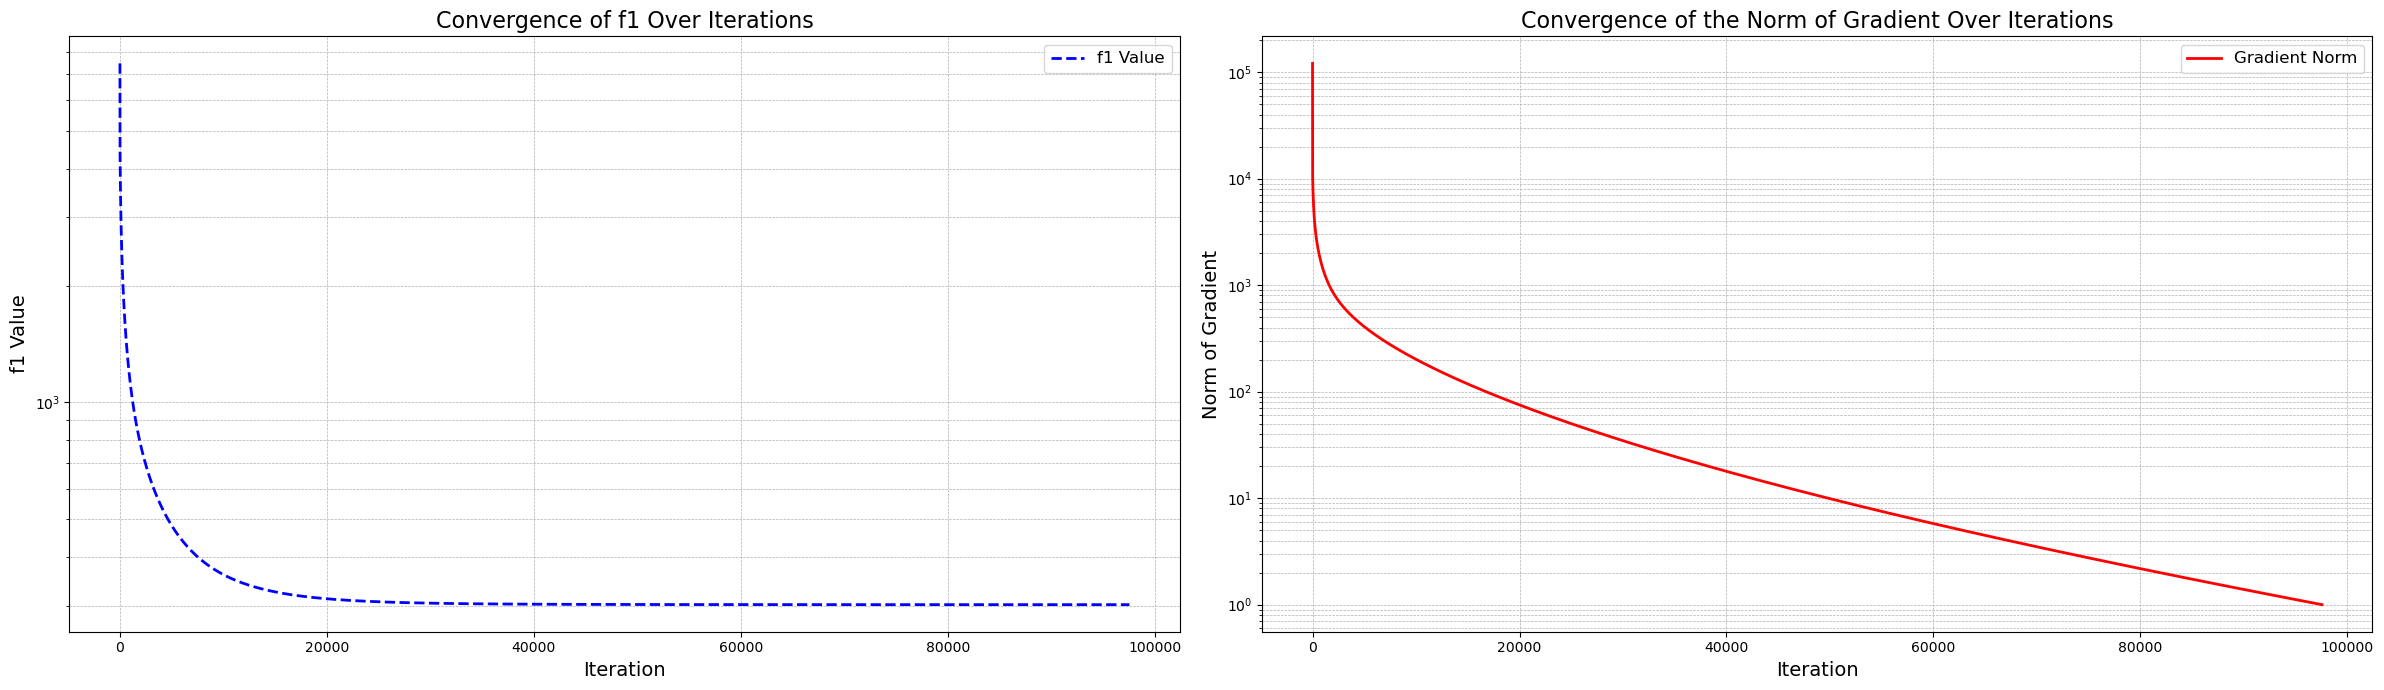

Number of iterations: 97546
Final norm of the gradient: 0.9999709342009704


In [16]:
# Gradient Descent algorithm 
max_iter = 100000  # Maximum number of iterations
tol = 1  # Tolerance for the norm of the gradient

norm_grad_list = []  # List to store the values of the norm of the gradient
f1_list = []  # List to store the values of f1

for k in range(max_iter):
    
    grad = grad_f1(w, A_train, b_train, lambda_)
    f1_val = f1(w, A_train, b_train, lambda_)
    
    norm_grad_list.append(np.linalg.norm(grad))
    f1_list.append(f1_val)
    
    if np.linalg.norm(grad) <= tol:
        break
    
    w = w - gamma * grad


# Plots for f1_list and norm_grad_list
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 7), dpi=100)

# Plot for f1_list on the first subplot
ax1.plot(f1_list, label='f1 Value', color='blue', linewidth=2, linestyle='--')
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('f1 Value', fontsize=14)
ax1.set_title('Convergence of f1 Over Iterations', fontsize=16)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.set_yscale('log')
ax1.legend(fontsize=12)

# Plot for norm_grad_list on the second subplot
ax2.plot(norm_grad_list, label='Gradient Norm', color='red', linewidth=2, linestyle='-')
ax2.set_xlabel('Iteration', fontsize=14)
ax2.set_ylabel('Norm of Gradient', fontsize=14)
ax2.set_title('Convergence of the Norm of Gradient Over Iterations', fontsize=16)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.set_yscale('log')
ax2.legend(fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

print(f"Number of iterations: {k}")
print(f"Final norm of the gradient: {np.linalg.norm(grad)}")
    

# 4. Regularization for a sparse model

**You may have seen that at the optimum, the parameter $w$ has many coordinates with small but nonzero values. In order to force most of them to be exactly 0 and thus, to concentrate on the really informative features, we can solve a Lasso problem, that is a least squares problem with $\ell_{1}$ regularization:**

$$
\min _{w} \frac{1}{2}\|A w-b\|^{2}+\lambda\|w\|_{1}
$$

## Question 4.1

**Write the objective function as $F_{2}=f_{2}+g_{2}$ where $f_{2}$ is differentiable and the proximal operator of $g_{2}$ is easy to compute. Recall the formula for $\operatorname{prox}_{g_{2}}$. Calculate the gradient of $f_{2}$.**

$$
min_{x \in \mathbb{R}^n}  \frac{1}{2}\|A w-b\|^{2}+\lambda\|w\|
$$

$$
P_i = prox_{g_{2}}(w_i) = argmin_{w \in \mathbb{R}^n} |w| + \frac{1}{2\lambda} \|w - w_i\|^2
$$

<!-- Using Fermat's rule, we have: -->

$$
\iff
$$

$$
\begin{align*}
0 &\in \partial \left[|.|(P_i) + \frac{1}{2\lambda}(. - w_i)^{2}(P_i)\right] \\
0 &\in \partial |.|(P_i) + \frac{1}{\lambda}(P_i - w_i) \\
\frac{1}{\lambda} (w_i - P_i) &\in  \partial |.|(P_i) \\

\frac{1}{\lambda} (w_i - P_i) &\in  
\Biggl\{
\begin{aligned}
-1,  P_i < 0\\
[-1,1],  P_i = 0\\
1,  P_i > 0 \\
\end{aligned}\\

P_i &\in  
\Biggl\{
\begin{aligned}
\lambda + w_i,  P_i < 0\\
w_i + [-\lambda,\lambda],  P_i = 0\\
w_i - \lambda ,  P_i > 0 \\
\end{aligned}

\end{align*}
$$

$$
\begin{align*}
&\text{If } \ P_i < 0 \Rightarrow P_i = \lambda + w_i < 0 \Rightarrow w_i < -\lambda \\
&\text{If } \ P_i > 0 \Rightarrow P_i = w_i - \lambda > 0 \Rightarrow w_i > \lambda \\
&\text{If } \ P_i = 0 \Rightarrow P_i \in [-\lambda,\lambda] \Rightarrow |w_i| \leq \lambda
\end{align*}
$$

$$
\ P_i \in
\Biggl\{
\begin{aligned}
x_i + \lambda, w_i < -\lambda \\
x_i - \lambda, w_i > \lambda \\
0, |w_i| \le \lambda \\
\end{aligned}
$$

Now we have to calculate the gradient of the function $f_{2}$:

As $f_{2}$ is defined by:
$$
\frac{1}{2}\|A w-b\|^{2}
$$

The gradient can be calculated by definition:

$$
\begin{align*}
f_{2}(\omega+h) &= \frac{1}{2}\|A(\omega + h) -b\|^{2} \\
&= \frac{1}{2}\|A \omega - b + A h\|^{2} \\

&= \frac{1}{2} \left\|A \omega - b\right\|^{2} + \left\langle A \omega - b, A h\right\rangle + \frac{1}{2} \left\|A h\right\|^{2} \\
&= f_{2}(\omega) + \left\langle A \omega - b, A h\right\rangle + o(h) \\
&= f_{2}(\omega) + \left\langle A^{T} (A\omega-b), h\right\rangle + o(h)
\end{align*}
$$

Finally:

$$
\nabla f_{2}(\omega) = A^{T}(A \omega -b)
$$

## Question 4.2
Code the proximal gradient method. Here, we will take $\lambda = 200$. What stopping test do you suggest ?

In [23]:
def soft_thresholding(x, lmbda):
    return np.sign(x) * np.maximum(0, np.abs(x) - lmbda)

def proximal_gradient_method(A, b, lmbda, max_iter=100000, tol=1e-5):
    n, m = A.shape
    w = np.zeros(m) 
    alpha = 1.0 / (np.linalg.norm(A.T @ A))

    for iteration in range(max_iter):
        
        gradient = A.T.dot(A.dot(w) - b)
        w_old = w.copy()
        w = w - alpha * gradient
        w = soft_thresholding(w, alpha * lmbda)

        if np.linalg.norm(w - w_old) < tol:
            break
    
    return w


result = proximal_gradient_method(A, b, 200)
print("Result : ", result)
print("Optimal Value:", np.linalg.norm(A @ result - b) ** 2 + 200 * np.linalg.norm(result, 1))


Result :  [ 0.  0.  0. ... -0.  0.  0.]
Optimal Value: 868.7013757510699


## Question 4.3

**We may try to accelerate the algorithm using line search. Compare the speed of the algorithm with ﬁxed step size and with line search**

/var/folders/7d/s11rptzs1b14v6dmv_xhv4mr0000gn/T/ipykernel_27038/1260461140.py:3: RuntimeWarning: overflow encountered in matmul
  return A.T @ (A @ w - b)
/var/folders/7d/s11rptzs1b14v6dmv_xhv4mr0000gn/T/ipykernel_27038/1260461140.py:16: RuntimeWarning: invalid value encountered in matmul
  function_value = 0.5 * np.linalg.norm(A @ w_new - b)**2 + lam * np.linalg.norm(w_new, 1)
/var/folders/7d/s11rptzs1b14v6dmv_xhv4mr0000gn/T/ipykernel_27038/1260461140.py:3: RuntimeWarning: invalid value encountered in matmul
  return A.T @ (A @ w - b)


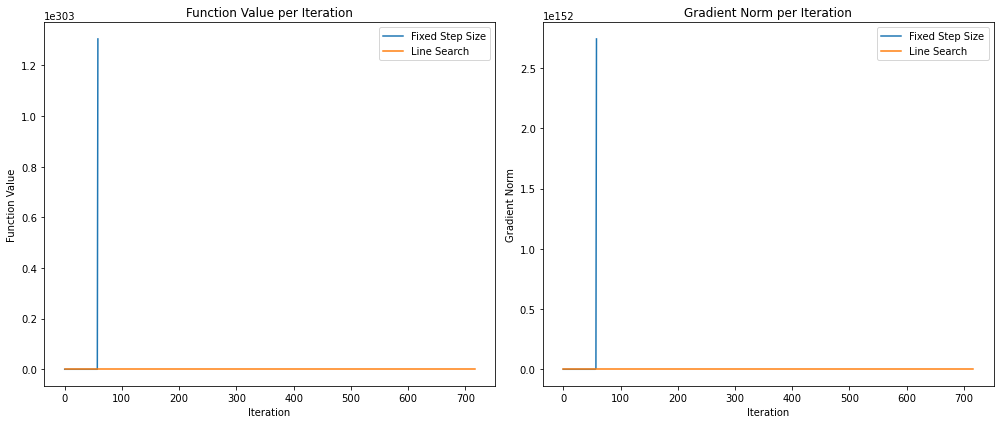

In [24]:
def gradient(A, b, w):
    return A.T @ (A @ w - b)

def proximal_gradient_method_with_logging(A, b, lam, max_iter=1000, tol=1e-5, alpha=1e-4):
    w = np.zeros(A.shape[1])  
    function_values = []
    gradient_norms = []
    for i in range(max_iter):
        # Gradient step
        grad = gradient(A, b, w)
        w_new = w - alpha * grad
        # Proximal step (applying the soft-thresholding)
        w_new = soft_thresholding(w_new, lam * alpha)
        # Logging
        function_value = 0.5 * np.linalg.norm(A @ w_new - b)**2 + lam * np.linalg.norm(w_new, 1)
        function_values.append(function_value)
        gradient_norm = np.linalg.norm(grad)
        gradient_norms.append(gradient_norm)
        # Check for convergence (using the norm of the difference between iterates)
        if np.linalg.norm(w_new - w) < tol:
            break
        w = w_new
    return w, i + 1, function_values, gradient_norms 

def proximal_gradient_method_with_line_search_and_logging(A, b, lam, max_iter=1000, tol=1e-5, alpha_start=1, beta=0.5, c=1e-4):
    w = np.zeros(A.shape[1])  
    function_values = []
    gradient_norms = []
    for i in range(max_iter):
        grad = gradient(A, b, w)
        alpha = alpha_start
        # Backtracking line search
        while True:
            w_new = w - alpha * grad
            w_temp = soft_thresholding(w_new, lam * alpha)
            function_value = 0.5 * np.linalg.norm(A @ w_temp - b)**2 + lam * np.linalg.norm(w_temp, 1)
            if function_value <= (0.5 * np.linalg.norm(A @ w - b)**2 + lam * np.linalg.norm(w, 1) - c * alpha * np.linalg.norm(grad)**2):
                break
            alpha *= beta
        w_new = w_temp
        # Logging
        function_values.append(function_value)
        gradient_norm = np.linalg.norm(grad)
        gradient_norms.append(gradient_norm)
        # Check for convergence (using the norm of the difference between iterates)
        if np.linalg.norm(w_new - w) < tol:
            break
        w = w_new
    return w, i + 1, function_values, gradient_norms  

# Now we will run both methods and plot the results
lamda_ = 200
w_fixed, iter_fixed, function_values_fixed, gradient_norms_fixed = proximal_gradient_method_with_logging(A_train, b_train, lambda_)
w_line_search, iter_line_search, function_values_line_search, gradient_norms_line_search = \
    proximal_gradient_method_with_line_search_and_logging(A_train, b_train, lambda_)

# Plotting
plt.figure(figsize=(14, 6))

# Function values plot
plt.subplot(1, 2, 1)
plt.plot(function_values_fixed, label='Fixed Step Size')
plt.plot(function_values_line_search, label='Line Search')
plt.title('Function Value per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Function Value')
plt.legend()

# Gradient norms plot
plt.subplot(1, 2, 2)
plt.plot(gradient_norms_fixed, label='Fixed Step Size')
plt.plot(gradient_norms_line_search, label='Line Search')
plt.title('Gradient Norm per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.legend()

plt.tight_layout()
plt.show()
